In [518]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors

import sys
import scipy.stats as stats
import scipy.optimize as opt
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist, squareform

import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

import os

import pyarrow as pa
import pyarrow.parquet as pq

from enum import Enum

from matplotlib.backends.backend_pdf import PdfPages 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# 30 sec

In [519]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()
matplotlib.rcParams["text.usetex"] = False

In [520]:
# Now import from Enum
sys.path.append('/groups/icecube/cyan/factory/DOMification')
from Enum.Flavour import Flavour
from Enum.EnergyRange import EnergyRange
from EventPeek.PseudoNormaliser import PseudoNormaliser

In [521]:
root_dir_noCR = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered/Snowstorm/PureNu/"
root_dir_noCR_CC = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered/Snowstorm/CC_CRclean/"
root_dir_noCR_CC_IN = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered/Snowstorm/CC_CRclean_Contained/"

In [522]:
Flavour.E.latex

'\\nu_e'

In [523]:
EnergyRange.ER_10_TEV_1_PEV.E

'22014'

In [524]:
EnergyRange.ER_10_TEV_1_PEV.latex

'$10\\,\\text{TeV} - 1\\,\\text{PeV}$'

In [525]:
dir_noCR_CC_IN_nu_e_10TeV_1PeV = os.path.join(root_dir_noCR_CC_IN, EnergyRange.ER_10_TEV_1_PEV.E)


In [526]:
dir_noCR_CC_IN_nu_e_10TeV_1PeV

'/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered/Snowstorm/CC_CRclean_Contained/22014'

In [527]:
files = [f for f in os.listdir(dir_noCR_CC_IN_nu_e_10TeV_1PeV) if f.endswith(".parquet")]
directories = [d for d in os.listdir(dir_noCR_CC_IN_nu_e_10TeV_1PeV) if os.path.isdir(os.path.join(dir_noCR_CC_IN_nu_e_10TeV_1PeV, d))]

In [528]:
files

['truth_3.parquet',
 'truth_2.parquet',
 'truth_6.parquet',
 'truth_4.parquet',
 'truth_1.parquet',
 'truth_5.parquet']

In [529]:
directories

['6', '1', '5', '2', '3', '4']

In [530]:
pmtfiles = [f for f in os.listdir(os.path.join(dir_noCR_CC_IN_nu_e_10TeV_1PeV, directories[0])) if f.endswith(".parquet")]

In [531]:
pmtfiles

['PMTfied_2.parquet', 'PMTfied_1.parquet']

In [532]:
def linear(x, coeff, offset):
    return coeff*x + offset

In [533]:
def get_energy_distribution_from_truth_file(truth_file: str, title: str = None):
    truth_df = pq.read_table(truth_file).to_pandas()
    energies = truth_df["energy"]

    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(energies, Nbins=50, isLog=True)

    valid_mask = counts > 0  # Avoid log(0) errors
    log_x = np.log10(bin_centers[valid_mask])
    log_y = np.log10(counts[valid_mask])
    
    # **Poisson errors (standard deviation) for log(y)**
    sigma = 1 / np.sqrt(counts[valid_mask])

    popt, pcov = opt.curve_fit(linear, log_x, log_y, sigma=sigma, absolute_sigma=True)# returns optimal parameters and covariance matrix
    slope, intercept = popt

    log_y_fit = linear(log_x, *popt)
    
    # **Compute χ², DOF, and p-value**
    residuals = (log_y - log_y_fit) / sigma
    chi2_value = np.sum(residuals**2)
    dof = len(log_y) - len(popt)  # Degrees of freedom
    p_value = stats.chi2.sf(chi2_value, dof)  # Compute p-value

    # **Plot Histogram and Fit**
    fig, ax = plt.subplots(figsize=(18, 13))
    ax.hist(energies, bins=bins, histtype='step', lw=2, color=getColour(0), label='Energy distribution')

    # **Plot Fit Line Only for Valid Data**
    y_fit = 10**linear(log_x, *popt)
    ax.plot(10**log_x, y_fit, label=f'Fit: $y = {slope:.2f}x + {intercept:.2f}$', color=getColour(1), linestyle='-')

    ax.legend()
    ax.set_xlabel(r'$\log_{10}(\mathrm{energy})$')
    ax.set_ylabel('Counts')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(fr"{title}")

    # **Summary statistics**
    d = {'N_events': f"{len(energies)}",
         'mean': f"{np.mean(energies):.3e}",
         'std': f"{np.std(energies):.3e}",
         'max': f"{np.max(energies):.3e}",
         'min': f"{np.min(energies):.3e}",
         'slope': f"{slope:.3f}",
         'intercept': f"{intercept:.3f}",
         'χ²': f"{chi2_value:.3f}",
         'DOF': f"{dof}",
         'p-value': f"{p_value:.3f}"}

    add_text_to_ax(0.65, 0.85, nice_string_output(d), ax, fontsize=12)
    return fig, ax


(<Figure size 1800x1300 with 1 Axes>,
 <Axes: title={'center': 'None'}, xlabel='$\\log_{10}(\\mathrm{energy})$', ylabel='Counts'>)

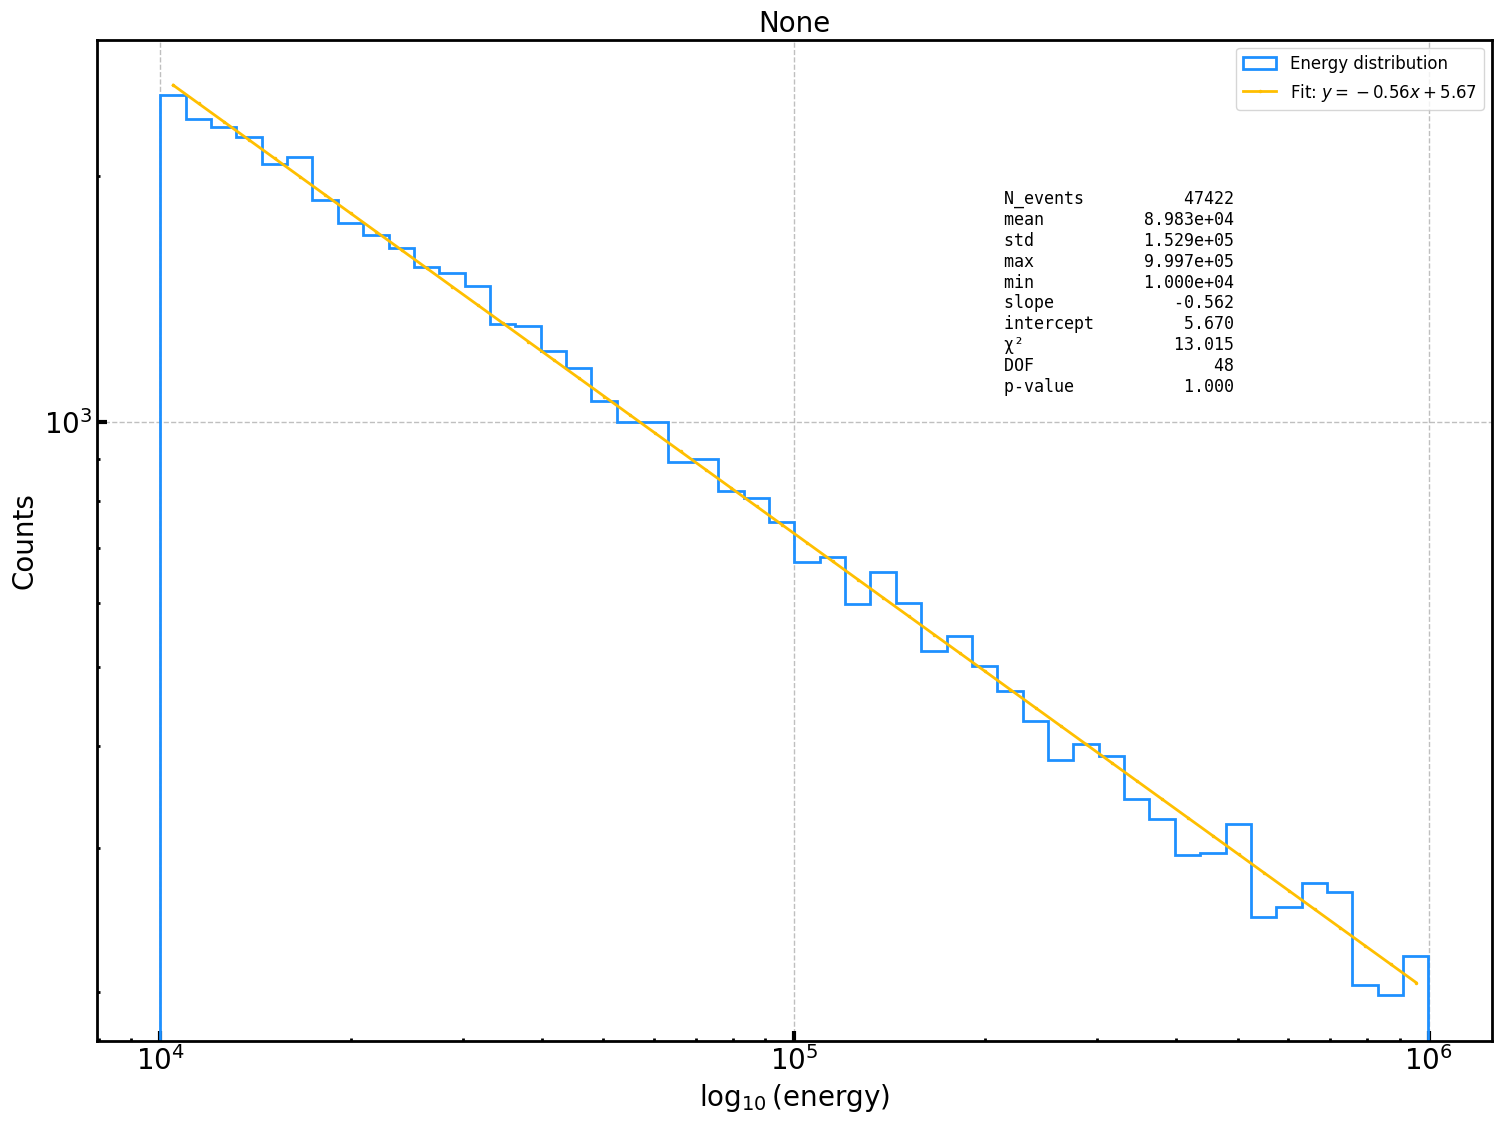

In [534]:
get_energy_distribution_from_truth_file(os.path.join(dir_noCR_CC_IN_nu_e_10TeV_1PeV, files[0]))

In [535]:
def get_interesting_events(truth_file:str, N_doms_cut = 1250):
    truth_df = pq.read_table(truth_file).to_pandas()
    N_doms = truth_df["N_doms"]
    
    interesting_event_no = truth_df[["event_no", "shard_no", "energy"]][N_doms > N_doms_cut]
    return interesting_event_no

In [536]:
get_interesting_events(os.path.join(dir_noCR_CC_IN_nu_e_10TeV_1PeV, files[0]))

event_no  shard_no      energy
18568  114000300530734         5  700944.500
24216  114000300557416         6  769607.250
24359  114000300558088         6  997287.375
45964  114000300659174        11  649459.250

In [537]:
def get_normalised_dom_features(pmt_event_df: pd.DataFrame, Q_cut: float = -1) -> pd.DataFrame:
    selected_columns = ["dom_x", "dom_y", "dom_z", "Qtotal", "t1"]
    event_np = pmt_event_df[selected_columns].to_numpy()
    normaliser = PseudoNormaliser()
    
    normalised_np = normaliser(event_np, column_names=selected_columns)
    normalised_df = pd.DataFrame(normalised_np, columns=selected_columns)
    normalised_df[["dom_x", "dom_y", "dom_z"]] = pmt_event_df[["dom_x", "dom_y", "dom_z"]].to_numpy()
    normalised_df = normalised_df[normalised_df["Qtotal"] > Q_cut] if Q_cut is not None else normalised_df

    return normalised_df

In [538]:
def add_string_column_to_event_df(event_df: pd.DataFrame, ref_position_df: pd.DataFrame, tolerance=2.0):
    event_df = event_df.copy()
    event_df['string'] = np.nan
    x_diff = np.square(ref_position_df['dom_x'].values[:, None] - event_df['dom_x'].values)
    y_diff = np.square(ref_position_df['dom_y'].values[:, None] - event_df['dom_y'].values)
    distances = np.sqrt(x_diff + y_diff)
    min_indices = np.argmin(distances, axis=0)
    within_tolerance = np.min(distances, axis=0) <= tolerance
    event_df.loc[within_tolerance, 'string'] = ref_position_df.iloc[min_indices[within_tolerance]]['string'].values
    return event_df

In [539]:
def get_flavour_ER_subdir_part(event_no: int):
    event_no_str = str(event_no)

    subdir_id = event_no_str[1:3]  # 2-digit subdirectory
    part_no = int(event_no_str[3:7])  # 4-digit part number
    original_event_no = int(event_no_str[7:])  # Remaining digits = event index
    subdir_no = f"220{subdir_id}"
    energy_range = EnergyRange.get_energy_range(subdir_no)
    flavour = EnergyRange.get_flavour(subdir_no)

    return subdir_no, part_no, original_event_no, energy_range, flavour


In [540]:
def generate_irregular_shape(n_points=100, noise=0.1, rotation_angle=np.pi/6):
    t = np.linspace(0, 2*np.pi, n_points)  # Parameter for ellipse
    x = 5 * np.cos(t)  # Semi-major axis = 5
    y = 2 * np.sin(t)  # Semi-minor axis = 2
    
    # Add noise
    x += np.random.normal(0, noise, n_points)
    y += np.random.normal(0, noise, n_points)

    # Apply rotation
    R = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                  [np.sin(rotation_angle), np.cos(rotation_angle)]])
    shape_points = np.dot(R, np.vstack((x, y)))

    return shape_points.T  # Transpose to get shape (n_points, 2)

def custom_PCA(points):
    mean = np.mean(points, axis=0)  # Compute mean
    centered_points = points - mean  # Center the data

    # Compute covariance matrix
    covariance_matrix = np.cov(centered_points, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues & eigenvectors (largest first)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Compute major & minor axis lengths
    major_axis_length = np.sqrt(eigenvalues[0])
    minor_axis_length = np.sqrt(eigenvalues[1])

    return major_axis_length, minor_axis_length, eigenvectors, mean

def plot_shape_with_PCA(points, eigenvectors, mean, major_length, minor_length):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot original points
    ax.scatter(points[:, 0], points[:, 1], label="Shape Points", color="blue", alpha=0.6)

    # Plot PCA axes
    for length, vector, color in zip([major_length, minor_length], eigenvectors.T, ["red", "green"]):
        line = np.array([mean - length * vector, mean + length * vector])
        ax.plot(line[:, 0], line[:, 1], color=color, linewidth=2, label=f"Principal Axis ({color})")

    # Annotate
    ax.scatter(mean[0], mean[1], color="black", label="Mean Center", zorder=3)
    ax.legend()
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.set_title("PCA of an Irregular Shape")
    ax.axis("equal")
    plt.show()

def run_understand_PCA():
    # Generate irregular shape
    shape_points = generate_irregular_shape()

    # Compute PCA
    major_length, minor_length, eigenvectors, mean = custom_PCA(shape_points)

    # Plot
    plot_shape_with_PCA(shape_points, eigenvectors, mean, major_length, minor_length)
run_understand_PCA()

In [541]:
def calculate_horizontal_boundary(pmt_event_df: pd.DataFrame):
    xy_points = pmt_event_df[['dom_x', 'dom_y']].to_numpy()

    # Extract the outermost boundary points using Convex Hull
    hull = ConvexHull(xy_points)
    boundary_points = xy_points[hull.vertices]  
    return boundary_points

In [542]:
border_xy = np.array(
    [
        (-256.1400146484375, -521.0800170898438),
        (-132.8000030517578, -501.45001220703125),
        (-9.13000011444092, -481.739990234375),
        (114.38999938964844, -461.989990234375),
        (237.77999877929688, -442.4200134277344),
        (361.0, -422.8299865722656),
        (405.8299865722656, -306.3800048828125),
        (443.6000061035156, -194.16000366210938),
        (500.42999267578125, -58.45000076293945),
        (544.0700073242188, 55.88999938964844),
        (576.3699951171875, 170.9199981689453),
        (505.2699890136719, 257.8800048828125),
        (429.760009765625, 351.0199890136719),
        (338.44000244140625, 463.7200012207031),
        (224.5800018310547, 432.3500061035156),
        (101.04000091552734, 412.7900085449219),
        (22.11000061035156, 509.5),
        (-101.05999755859375, 490.2200012207031),
        (-224.08999633789062, 470.8599853515625),
        (-347.8800048828125, 451.5199890136719),
        (-392.3800048828125, 334.239990234375),
        (-437.0400085449219, 217.8000030517578),
        (-481.6000061035156, 101.38999938964844),
        (-526.6300048828125, -15.60000038146973),
        (-570.9000244140625, -125.13999938964844),
        (-492.42999267578125, -230.16000366210938),
        (-413.4599914550781, -327.2699890136719),
        (-334.79998779296875, -424.5),
    ]
)
# calculate the area within the 2d border 
IceCube_area = ConvexHull(border_xy).volume
print(f"Area of IceCube: {IceCube_area:.2f} m²")

Area of IceCube: 867598.99 m²


In [543]:
def calculate_horizontal_PCA(boundary_points: np.ndarray):
    # Compute the mean (centre) of the shape
    centre = np.mean(boundary_points, axis=0)

    # Perform PCA to find the principal axes
    pca = PCA(n_components=2)
    pca.fit(boundary_points)

    # Extract eigenvalues and eigenvectorscd
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_

    # Compute major and minor axis lengths (sqrt of eigenvalues)
    major_axis_length, minor_axis_length = np.sqrt(eigenvalues)

    return major_axis_length, minor_axis_length, eigenvectors, centre

In [544]:
def compute_max_extent(boundary_points: np.ndarray) -> tuple:
    dist_matrix = squareform(pdist(boundary_points, metric="euclidean"))
    i, j = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)
    point1, point2 = boundary_points[i], boundary_points[j]
    return point1, point2, dist_matrix[i, j]

In [545]:
def get_cos_squared_extent_PCA_major(extent_end1: np.ndarray, 
                                    extent_end2: np.ndarray, 
                                    extent_max: float,
                                    eigen_vectors: np.ndarray,
                                    major_PCA: float) -> float:
    if major_PCA == 0 or extent_max == 0:
        return np.nan
    extent_vector = extent_end2 - extent_end1
    extent_unit_vector = extent_vector / np.linalg.norm(extent_vector)
    pca_major_vector = eigen_vectors[0]
    cos_theta_squared = (np.dot(extent_unit_vector, pca_major_vector) ** 2)
    return cos_theta_squared

In [546]:
def find_gmm_centres(string_df: pd.DataFrame, n_components=2):
    if string_df.shape[0] < n_components:
        return None, None  # Not enough points for clustering
    points = string_df[['dom_x', 'dom_y']].values
    weights = string_df['Qtotal'].to_numpy()
    weights = np.clip((weights / (weights.max() + 1e-7)) * 10, 1, 10).astype(int)
    weighted_points = np.repeat(points, weights, axis=0)
    # weighted_points = np.concatenate([points[i].reshape(1, -1).repeat(w, axis=0) for i, w in enumerate(weights)])
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(weighted_points)  # No `sample_weight` needed
    centres = gmm.means_
    cluster_dist = np.linalg.norm(centres[0] - centres[1])  # Distance between clusters
    std_dev = np.std(points, axis=0).mean()
    separation_score = cluster_dist / (std_dev + 1e-7)
    return centres, separation_score

In [547]:
def find_meanshift_centres(string_df: pd.DataFrame):
    if string_df.shape[0] < 2:
        return None, None  # Not enough points for clustering
    points = string_df[['dom_x', 'dom_y']].to_numpy()
    weights = string_df['Qtotal'].to_numpy()
    weights = np.clip((weights / (weights.max() + 1e-7)) * 10, 1, 10).astype(int)

    # Expand dataset by repeating points based on weights
    weighted_points = np.repeat(points, weights, axis=0)
    # bandwidth = estimate_bandwidth(points, quantile=0.2, n_samples=500)
    bandwidth = 150.0
    ms = MeanShift(bandwidth=bandwidth)
    ms.fit(weighted_points)
    centres = ms.cluster_centers_
    if len(centres) < 2:
        return centres, 0  # Only one cluster found
    cluster_distances = np.linalg.norm(centres[:, None] - centres, axis=-1)
    max_dist = np.max(cluster_distances)
    std_dev = np.std(points, axis=0).mean()
    separation_score = max_dist / (std_dev + 1e-7)
    return centres, separation_score

In [548]:
def find_kmeans_centres(string_df: pd.DataFrame, n_clusters=2):
    if string_df.shape[0] < n_clusters:
        return None, None  # Not enough points for clustering
    points = string_df[['dom_x', 'dom_y']].values
    weights = string_df['Qtotal'].to_numpy()
    weights = np.clip((weights / (weights.max() + 1e-7)) * 10, 1, 10).astype(int)
    weighted_points = np.repeat(points, weights, axis=0)
    # weighted_points = np.concatenate([points[i].reshape(1, -1).repeat(w, axis=0) for i, w in enumerate(weights)])
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(weighted_points)
    centres = kmeans.cluster_centers_
    cluster_dist = np.linalg.norm(centres[0] - centres[1])
    std_dev = np.std(points, axis=0).mean()
    separation_score = cluster_dist / (std_dev + 1e-7)
    return centres, separation_score

In [549]:
def compute_area_ratio(boundary_points: np.ndarray):
    area = ConvexHull(boundary_points).volume
    return area / IceCube_area

In [550]:
def compute_normalised_weighted_distance(string_df: pd.DataFrame):
    points = string_df[['dom_x', 'dom_y']].to_numpy()
    weights = string_df['Qtotal'].to_numpy()
    
    centroid = np.average(points, axis=0, weights=weights)
    distances = np.linalg.norm(points - centroid, axis=1)
    total_weighted_distance = np.sum(distances * weights)
    
    total_Q_total = np.sum(weights)
    return total_weighted_distance / total_Q_total

In [551]:
def compute_outer_mass_fraction(string_df: pd.DataFrame, num_bins=10):
    if string_df.shape[0] < 3:
        return np.nan  # Not enough points
    eps = 1e-8
    points = string_df[['dom_x', 'dom_y']].to_numpy()
    weights = string_df['Qtotal'].to_numpy()
    if np.all(np.isnan(weights)) or np.all(weights == 0):
        return np.nan
    centroid = np.average(points, axis=0, weights=weights)
    distances = np.linalg.norm(points - centroid, axis=1)
    if np.all(distances == 0):  # All points are identical
        return np.nan
    max_dist = np.nanmax(distances)
    bins = np.linspace(0, max_dist, num_bins + 1)
    mass_distribution, _ = np.histogram(distances, bins=bins, weights=weights)
    outer_mass = np.sum(mass_distribution[num_bins // 2:])  # Sum outer half
    total_mass = np.sum(mass_distribution)
    if total_mass == 0:
        print("⚠️ Warning: Total mass is zero. Returning NaN.")
        return np.nan
    outer_mass_fraction = outer_mass / (total_mass + eps)
    return outer_mass_fraction

In [552]:
def calculate_vertical_stretch(pmt_event_df: pd.DataFrame):
    stretch_per_string = pmt_event_df.groupby("string")["dom_z"].agg(lambda x: x.max() - x.min())
    if stretch_per_string.empty:
        return np.nan, np.nan, [np.nan, np.nan], np.nan
    stretch_mean = stretch_per_string.mean()
    stretch_max = stretch_per_string.max()
    top_one_sigma = stretch_per_string.quantile(0.843)
    bottom_one_sigma = stretch_per_string.quantile(0.157)
    half_interquartile_range = (top_one_sigma - bottom_one_sigma) / 2
    if stretch_per_string.empty or np.isnan(stretch_mean) or np.isnan(stretch_max):
        return np.nan, np.nan, [np.nan, np.nan], np.nan
    if stretch_per_string.isna().all():
        return np.nan, np.nan, [np.nan, np.nan], np.nan
    try:
        max_string = stretch_per_string.idxmax()
        max_z_positions = pmt_event_df.loc[pmt_event_df["string"] == max_string, "dom_z"].agg(["min", "max"]).values
    except Exception:
        max_string, max_z_positions = np.nan, [np.nan, np.nan]

    return stretch_mean, stretch_max, max_z_positions, half_interquartile_range

In [553]:
def get_string_df(event_df: pd.DataFrame):
    # create a new dataframe having rows of unique strings
    # store the dom_x, dom_y, and sum of the Qtotal for all the doms in the string
    string_df = event_df.groupby("string").agg({"dom_x": "mean", "dom_y": "mean", "Qtotal": "sum"})
    string_df.reset_index(inplace=True)
    return string_df

In [592]:
def plot_DOM_heatmap_for_this_event(pmt_event_df: pd.DataFrame, shard_no:int, energy:int, Q_cut:int = -1, elev=45, azim=105):
    position_file = "/groups/icecube/cyan/factory/DOMification/dom_ref_pos/unique_string_dom_completed.csv"
    position_df = pd.read_csv(position_file)
    pmt_event_df = add_string_column_to_event_df(pmt_event_df, position_df)

    # Normalise the event DataFrame
    pseudo_normalised_df = get_normalised_dom_features(pmt_event_df, Q_cut)
    pseudo_normalised_df = add_string_column_to_event_df(pseudo_normalised_df, position_df)
    
    fig, ax = plt.subplots(figsize=(18, 13), subplot_kw={'projection': '3d'})
    # **Plot reference DOM positions as small grey dots (background)**
    ax.scatter(
        position_df["dom_x"], position_df["dom_y"], position_df["dom_z"],
        color=getColour(1), marker=".", s=10, label="Reference DOMs", zorder=1
    )

    border_xy = calculate_horizontal_boundary(pseudo_normalised_df)
    major_PCA, minor_PCA, eigenvectors, centre_PCA = calculate_horizontal_PCA(border_xy)
    eccentricity_PCA = np.sqrt(1 - (minor_PCA / major_PCA)**2)
    aspect_contrast_PCA = (major_PCA - minor_PCA) / (major_PCA + minor_PCA)
    
    xy_end1, xy_end2, extent_max = compute_max_extent(border_xy)
    cos_sq = get_cos_squared_extent_PCA_major(xy_end1, xy_end2, extent_max, eigenvectors, major_PCA)
    stretch_mean, stretch_max, max_z_positions, stretch_hiqr = calculate_vertical_stretch(pseudo_normalised_df)
    string_df = get_string_df(pseudo_normalised_df) # string, dom_x, dom_y, Qtotal
    
    gmm_centres, gmm_score = find_gmm_centres(string_df)
    ms_centres, ms_score = find_meanshift_centres(string_df)
    kmeans_centres, kmeans_score = find_kmeans_centres(string_df)
    # dispersion = compute_dispersion(string_df, get_string_df(pmt_event_df))
    area_ratio = compute_area_ratio(border_xy)
    normalised_weighted_distance = compute_normalised_weighted_distance(string_df)
    outer_mass_fraction = compute_outer_mass_fraction(string_df)
    
    # Extract relevant columns
    dom_x = pseudo_normalised_df["dom_x"]
    dom_y = pseudo_normalised_df["dom_y"]
    dom_z = pseudo_normalised_df["dom_z"]
    Qtotal = pseudo_normalised_df["Qtotal"]
    t1 = pseudo_normalised_df["t1"]

    # Marker size scaling
    min_marker_size, max_marker_size = 10, 200
    Qmin, Qmax = Qtotal.min(), Qtotal.max()
    marker_sizes = min_marker_size + (Qtotal - Qmin) / (Qmax - Qmin) * (max_marker_size - min_marker_size)

    # Normalise arrival time for colormap
    t_norm = mcolors.Normalize(vmin=t1.min(), vmax=t1.max())

    # **Plot event scatter points (foreground)**
    sc = ax.scatter(dom_x, dom_y, dom_z, c=t1, cmap="cool", norm=t_norm,
                    s=marker_sizes, alpha=0.8, edgecolors='black', linewidth=0.5, zorder=2)

    # Colorbar for arrival time
    cbar = plt.colorbar(sc, ax=ax, pad=0.1, shrink=0.75)
    cbar.set_label("Adjusted Arrival Time (t1)")
    
    
    # plot every horizontal projection in this z level
    TEXT_Z = 600
    
    # Create top boundary polygon (XY Boundary)
    verts_top = [np.column_stack((border_xy[:, 0], border_xy[:, 1], np.full(border_xy.shape[0], TEXT_Z)))]
    # ax.add_collection3d(Poly3DCollection(
    # verts_top, facecolors=getColour(6), alpha=0.2, label='XY Boundary (Top)', zsort='min'))
    poly = Poly3DCollection(
        verts_top, facecolors=getColour(6), alpha=0.15, label='XY Boundary (Top)', zsort='min', zorder=1
    )
    poly.set_zsort('max')

    ax.add_collection3d(poly)
    
    for x, y in border_xy:
        ax.plot([x, x], [y, y], TEXT_Z, color=getColour(6), alpha=0.5)
        
    # **PCA axes**
    major_axis_endpoints = np.array([
        centre_PCA[:2] - major_PCA * eigenvectors[0],
        centre_PCA[:2] + major_PCA * eigenvectors[0]
    ])
    minor_axis_endpoints = np.array([
        centre_PCA[:2] - minor_PCA * eigenvectors[1],
        centre_PCA[:2] + minor_PCA * eigenvectors[1]
    ])
    
    major_axis_3d = np.column_stack((major_axis_endpoints, np.full(2, TEXT_Z)))
    minor_axis_3d = np.column_stack((minor_axis_endpoints, np.full(2, TEXT_Z)))
    ax.plot(major_axis_3d[:, 0], major_axis_3d[:, 1], major_axis_3d[:, 2], color=getColour(2), linewidth=3, label="PCA XY major", zorder=5)
    ax.plot(minor_axis_3d[:, 0], minor_axis_3d[:, 1], minor_axis_3d[:, 2], color=getColour(3), linewidth=3, label="PCA XY minor", zorder=5)
    
    # **MeanShift centre point** 
    ax.scatter(ms_centres[:, 0], ms_centres[:, 1], TEXT_Z, color=getColour(7), s=100, marker="x", label="MeanShift Centre", zorder = 5, depthshade=False)
    # **GMM centre point**
    ax.scatter(gmm_centres[:, 0], gmm_centres[:, 1], TEXT_Z, color=getColour(4), s=100, marker="x", label="GMM Centre", zorder = 5, depthshade=False)
    # **KMeans centre point**
    ax.scatter(kmeans_centres[:, 0], kmeans_centres[:, 1], TEXT_Z, color=getColour(8), s=100, marker="x", label="KMeans Centre", zorder = 5, depthshade=False)
    
    # **Max extent line**
    max_extent_3d = np.array([
        [xy_end1[0], xy_end1[1], TEXT_Z],
        [xy_end2[0], xy_end2[1], TEXT_Z]
    ])
    ax.plot(max_extent_3d[:, 0], max_extent_3d[:, 1], max_extent_3d[:, 2], 
            color=getColour(0), linewidth=3, linestyle="dashed", label="Max XY extent", zorder=5)

    # **Z Stretch lines**
    z_mean_at_this_xy = (575, 475)
    z_max_at_this_xy = (625, 525)
    ax.plot([z_mean_at_this_xy[0], z_mean_at_this_xy[0]], [z_mean_at_this_xy[1], z_mean_at_this_xy[1]], stretch_mean, 
            color=getColour(5), linewidth=3, label="Mean Z Stretch")

    ax.plot([z_max_at_this_xy[0], z_max_at_this_xy[0]], [z_max_at_this_xy[1], z_max_at_this_xy[1]], stretch_max, 
            color=getColour(8), linewidth=3,  label="Max Z Stretch")
    
    ax.legend(loc="upper right")
        
    
    # **Create a marker size legend**
    size_legend_values = np.linspace(Qmin, Qmax, num=4)
    size_legend_markers = min_marker_size + (size_legend_values - Qmin) / (Qmax - Qmin) * (max_marker_size - min_marker_size)

    # Position the legend outside the plot
    legend_ax = fig.add_axes([0.85, 0.05, 0.075, 0.1])  # [left, bottom, width, height]
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])
    legend_ax.set_title(
        rf"$Q_{{\text{{adjusted}}}} = \log_{{10}}(Q_{{\text{{total}}}}) - 2$" +'\n'+
        rf"$t1_{{\text{{adjusted}}}} = (t1 - 10^4) \times (3 \times 10^4)^{{-1}}$",
        fontsize=14
    )
    
    for size, q in zip(size_legend_markers, size_legend_values):
        legend_ax.scatter([], [], s=size, edgecolors='black', facecolors='none', label=f"{q:.2f}")

    legend_ax.legend(loc="center", frameon=False, fontsize=10)

    # **Statistics Dictionary**
    event_no = pmt_event_df["event_no"].iloc[0]
    subdir_no, part_no, original_event_no, energy_range, flavour = get_flavour_ER_subdir_part(event_no)
    
    # **String labels**
    for i in range(len(string_df)):
        ax.text(string_df['dom_x'].iloc[i], string_df['dom_y'].iloc[i], TEXT_Z,
                f'{int(string_df["string"].iloc[i])}', fontsize=10, ha='center', color='black')
    d_class = {
        "event_no": f"{original_event_no}",
        "part, shard": f"{part_no}, {int(shard_no)}",
        "PCA XY major": f"{major_PCA:.3f}",
        "PCA XY minor": f"{minor_PCA:.3f}",
        "eccentricity": f"{eccentricity_PCA:.3f}",
        "aspect contrast": f"{aspect_contrast_PCA:.3f}",
        "max XY extent": f"{extent_max:.3f}",
        "cos_sq_extent_PCA_major": f"{cos_sq:.3f}",
        "mean Z stretch": f"{stretch_mean:.3f}",
        "max Z stretch": f"{stretch_max:.3f}",
        "GMM score" : f"{gmm_score:.3f}",
        "MeanShift score" : f"{ms_score:.3f}",
        "KMeans score" : f"{kmeans_score:.3f}",
        "area ratio": f"{area_ratio:.3f}",
        "Sum Q distance": f"{normalised_weighted_distance:.3f}",
        "outer mass fraction": f"{outer_mass_fraction:.3f}",
    }
    
    original_Qtot = pmt_event_df["Qtotal"]
    original_t1 = pmt_event_df["t1"]
    N_dom_original = len(pmt_event_df)
    d_original_event = {
        "original values": "",
        "N_doms": f"{N_dom_original}",
        "Qtotal max": f"{original_Qtot.max():.3f}",
        "Qtotal mean": f"{original_Qtot.mean():.3f}",
        "Qtotal median": f"{original_Qtot.median():.3f}",
        "t1 max": f"{original_t1.max():.3f}",
        "t1 min": f"{original_t1.min():.3f}",
        "t1 mean": f"{original_t1.mean():.3f}",
        "t1 median": f"{original_t1.median():.3f}",
    }
    N_dom_cut = len(pseudo_normalised_df)
    d_pseudo_normalised = {
        "adjusted values": "",
        f"N_DOM(Q>{Q_cut})": f"{N_dom_cut}({N_dom_cut/N_dom_original:.2f})",
        f"Qtotal max": f"{Qtotal.max():.3f}",
        f"Qtotal mean": f"{Qtotal.mean():.3f}",
        f"Qtotal median": f"{Qtotal.median():.3f}",
        f"t1 max": f"{t1.max():.3f}",
        f"t1 min": f"{t1.min():.3f}",
        f"t1 mean": f"{t1.mean():.3f}",
        f"t1 median": f"{t1.median():.3f}",
    }

    # ✅ Add text using fig.text() to ensure correct positioning
    fig.text(0.15, 0.88, nice_string_output(d_class), fontsize=12, family='monospace', verticalalignment='top', color='black')
    fig.text(0.15, 0.20, nice_string_output(d_original_event), fontsize=12, family='monospace', verticalalignment='top', color='black')
    fig.text(0.62, 0.25, nice_string_output(d_pseudo_normalised), fontsize=12, family='monospace', verticalalignment='top', color='black')

    # **Set plot labels**
    ax.set_xlabel("X position (m)")
    ax.set_ylabel("Y position (m)")
    ax.set_zlabel("Z position (m)")
    ax.set_title(rf"$Q_{{\text{{adjusted}}}}$ and $t1_{{\text{{adjusted}}}}$ of ${flavour.latex}$ ({energy:.3e} $\text{{GeV}}$)")
    # change the x and y axes direction
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    # Adjust viewing angle
    ax.view_init(elev=elev, azim=azim)

    # plt.legend()  # Ensure labels appear
    plt.show()
    
    return fig, ax


In [593]:
def plot_string_XY_property(pmt_event_df: pd.DataFrame, shard_no:int, energy:int, Q_cut:int = -1):
    position_file = "/groups/icecube/cyan/factory/DOMification/dom_ref_pos/unique_string_dom_completed.csv"
    position_df = pd.read_csv(position_file)
    pmt_event_df = add_string_column_to_event_df(pmt_event_df, position_df)
    pseudo_normalised_df = get_normalised_dom_features(pmt_event_df, Q_cut)
    pseudo_normalised_df = add_string_column_to_event_df(pseudo_normalised_df, position_df)
    string_df = get_string_df(pseudo_normalised_df)  # string, dom_x, dom_y, Qtotal
    border_xy = calculate_horizontal_boundary(pseudo_normalised_df)
    major_PCA, minor_PCA, eigenvectors, centre_PCA = calculate_horizontal_PCA(border_xy)
    eccentricity_PCA = np.sqrt(1 - (minor_PCA / major_PCA)**2)
    aspect_contrast_PCA = (major_PCA - minor_PCA) / (major_PCA + minor_PCA)
    
    xy_end1, xy_end2, extent_max = compute_max_extent(border_xy)
    cos_sq = get_cos_squared_extent_PCA_major(xy_end1, xy_end2, extent_max, eigenvectors, major_PCA)
    string_df = get_string_df(pseudo_normalised_df) # string, dom_x, dom_y, Qtotal
    
    gmm_centres, gmm_score = find_gmm_centres(string_df)
    ms_centres, ms_score = find_meanshift_centres(string_df)
    kmeans_centres, kmeans_score = find_kmeans_centres(string_df)
    # dispersion = compute_dispersion(string_df, get_string_df(pmt_event_df))
    area_ratio = compute_area_ratio(border_xy)
    normalised_weighted_distance = compute_normalised_weighted_distance(string_df)
    outer_mass_fraction = compute_outer_mass_fraction(string_df)
    
    fig, ax = plt.subplots(figsize=(15, 12))

    # **Reference DOM XY positions**
    ax.scatter(
        position_df["dom_x"], position_df["dom_y"], color=getColour(1), marker=".", s=10, label="Reference DOM XY position", zorder=1
    )

    # **Boundary and enclosed area** 
    enclosed_points = np.vstack((border_xy, border_xy[0]))  # Close the loop
    ax.fill(enclosed_points[:, 0], enclosed_points[:, 1], color=getColour(6), alpha=0.2, label="XY Boundary", zorder=2)

    # Mark the enclosed points with the weight of Qtotal
    Qtotal = string_df["Qtotal"]
    min_marker_size, max_marker_size = 5, 300
    Qmin, Qmax = Qtotal.min(), Qtotal.max()
    marker_sizes = min_marker_size + (Qtotal - Qmin) / (Qmax - Qmin) * (max_marker_size - min_marker_size)

    sc = ax.scatter(
        string_df['dom_x'], string_df['dom_y'], s=marker_sizes, c=Qtotal, cmap='YlGnBu', alpha=0.8, 
        edgecolors='black', linewidth=0.5, zorder=3
    )
    cbar = plt.colorbar(sc, ax=ax, pad=0.1, shrink=0.85)
    cbar.set_label("Sum adjusted Qtotal")

    # **PCA axes**
    major_axis_endpoints = np.array([
        centre_PCA[:2] - major_PCA * eigenvectors[0],
        centre_PCA[:2] + major_PCA * eigenvectors[0]
    ])
    minor_axis_endpoints = np.array([
        centre_PCA[:2] - minor_PCA * eigenvectors[1],
        centre_PCA[:2] + minor_PCA * eigenvectors[1]
    ])
    ax.plot(major_axis_endpoints[:, 0], major_axis_endpoints[:, 1], color=getColour(2), linewidth=3, label="PCA XY major")
    ax.plot(minor_axis_endpoints[:, 0], minor_axis_endpoints[:, 1], color=getColour(3), linewidth=3, label="PCA XY minor")
    
    # ** Max Extent Line**
    ax.plot([xy_end1[0], xy_end2[0]], [xy_end1[1], xy_end2[1]], color=getColour(0), linestyle='-', linewidth=3, label="Max XY extent")
    
    # **Mean Shift Centres**
    ax.scatter(ms_centres[:, 0], ms_centres[:, 1], s=100, color=getColour(7), marker="x", label="Mean Shift Centres", zorder=4)
    # **GMM Centres**
    ax.scatter(gmm_centres[:, 0], gmm_centres[:, 1], s=100, color=getColour(4), marker="x", label="GMM Centres", zorder=4)
    # **K-means Centres**
    ax.scatter(kmeans_centres[:, 0], kmeans_centres[:, 1], s=100, color=getColour(8), marker="x", label="K-means Centres", zorder=4)

    # **String Number with Adaptive Colouring**
    whitening_Q_cut = np.quantile(Qtotal, 0.80)
    for i in range(len(string_df)):
        x, y, string_num, q_value = string_df.loc[i, ['dom_x', 'dom_y', 'string', 'Qtotal']]
        text_colour = 'white' if q_value > whitening_Q_cut else 'black'  # High Q -> White, Low Q -> Black
        ax.text(x, y, f'{int(string_num)}', fontsize=10, ha='center', color=text_colour)
    
    # **Create a marker size legend**
    size_legend_values = np.linspace(Qmin, Qmax, num=4)
    size_legend_markers = min_marker_size + (size_legend_values - Qmin) / (Qmax - Qmin) * (max_marker_size - min_marker_size)
    legend_ax = fig.add_axes([0.85, 0.05, 0.075, 0.1])  # [left, bottom, width, height]
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])
    legend_ax.set_title(r"$\sum Q_{\text{adjusted}}$" + "\n" + r"($Q_{\text{adjusted}} = \log_{10}(Q_{\text{total}}) - 2)$", fontsize=14)
    for size, q in zip(size_legend_markers, size_legend_values):
        legend_ax.scatter([], [], s=size, edgecolors='black', facecolors='none', label=f"{q:.2f}")
    legend_ax.legend(loc="center", frameon=False, fontsize=10)
    
    # **Statistics Dictionary**
    event_no = pmt_event_df["event_no"].iloc[0]
    subdir_no, part_no, original_event_no, energy_range, flavour = get_flavour_ER_subdir_part(event_no)
    d_class = {
        "event_no": f"{original_event_no}",
        "part, shard": f"{part_no}, {int(shard_no)}",
        "PCA major": f"{major_PCA:.3f}",
        "PCA minor": f"{minor_PCA:.3f}",
        "eccentricity": f"{eccentricity_PCA:.3f}",
        "aspect contrast": f"{aspect_contrast_PCA:.3f}",
        "max extent": f"{extent_max:.3f}",
        "cos_sq_extent_PCA_major": f"{cos_sq:.3f}",
        "Gaussian Mixture": f"{gmm_score:.3f}",
        "Mean Shift": f"{ms_score:.3f}",
        "K-means": f"{kmeans_score:.3f}",
        "Area ratio": f"{area_ratio:.3f}",
        "Sum Q distance": f"{normalised_weighted_distance:.3f}",
        "Outer mass fraction": f"{outer_mass_fraction:.3f}",
        }
    
    original_Qtot = pmt_event_df["Qtotal"]
    original_t1 = pmt_event_df["t1"]
    N_dom_original = len(pmt_event_df)
    d_original_event = {
        "original values": "",
        "N_doms": f"{N_dom_original}",
        "Qtotal max": f"{original_Qtot.max():.3f}",
        "Qtotal mean": f"{original_Qtot.mean():.3f}",
        "Qtotal median": f"{original_Qtot.median():.3f}",
        "t1 max": f"{original_t1.max():.3f}",
        "t1 min": f"{original_t1.min():.3f}",
        "t1 mean": f"{original_t1.mean():.3f}",
        "t1 median": f"{original_t1.median():.3f}",
    }
    N_dom_cut = len(pseudo_normalised_df)
    t1 = pseudo_normalised_df["t1"]
    d_pseudo_normalised = {
        "adjusted values": "",
        f"N_DOM(Q>{Q_cut})": f"{N_dom_cut}({N_dom_cut/N_dom_original:.2f})",
        f"Qtotal max": f"{Qtotal.max():.3f}",
        f"Qtotal mean": f"{Qtotal.mean():.3f}",
        f"Qtotal median": f"{Qtotal.median():.3f}",
        f"t1 max": f"{t1.max():.3f}",
        f"t1 min": f"{t1.min():.3f}",
        f"t1 mean": f"{t1.mean():.3f}",
        f"t1 median": f"{t1.median():.3f}",
    }
    
    add_text_to_ax(0.02, 0.99, nice_string_output(d_class), ax, fontsize=10)
    add_text_to_ax(0.85, 0.99, nice_string_output(d_original_event), ax, fontsize=10)
    add_text_to_ax(0.85, 0.82, nice_string_output(d_pseudo_normalised), ax, fontsize=10)
    
    ax.legend(loc="lower right")
    ax.set_xlabel("X position (m)")
    ax.set_ylabel("Y position (m)")
    ax.set_title(rf"Sum of $Q_{{\text{{adjusted}}}}$ per String of ${flavour.latex}$ ({energy:.3e} $\text{{GeV}}$)")


In [594]:
def plot_events_from_this_part(root_before_subdir:str, subdir:str, part: int, N_doms_cut:int = 1250, Q_cut: float = -1, elev=45, azim=105):
    subdir_path = os.path.join(root_before_subdir, subdir)
    truth_file = os.path.join(root_before_subdir, subdir, f"truth_{part}.parquet")
    interesting_events = get_interesting_events(truth_file = truth_file, N_doms_cut = N_doms_cut)
    energy_range = EnergyRange.get_energy_range(subdir).latex
    flavour = EnergyRange.get_flavour(subdir).latex
    title_for_energy_spectrum = f"${flavour}$,  {energy_range}   (part {part})"
    # get_energy_distribution_from_truth_file(truth_file, title = title_for_energy_spectrum)
    for event_no, shard_no, energy in interesting_events.values:
        pmt_shard_df = pq.read_table(os.path.join(subdir_path, str(part), f"PMTfied_{int(shard_no)}.parquet")).to_pandas()
        pmt_event_df = pmt_shard_df[pmt_shard_df["event_no"] == event_no]
        plot_DOM_heatmap_for_this_event(pmt_event_df, shard_no, energy, Q_cut, elev=elev, azim=azim)
        plot_string_XY_property(pmt_event_df, shard_no, energy, Q_cut)

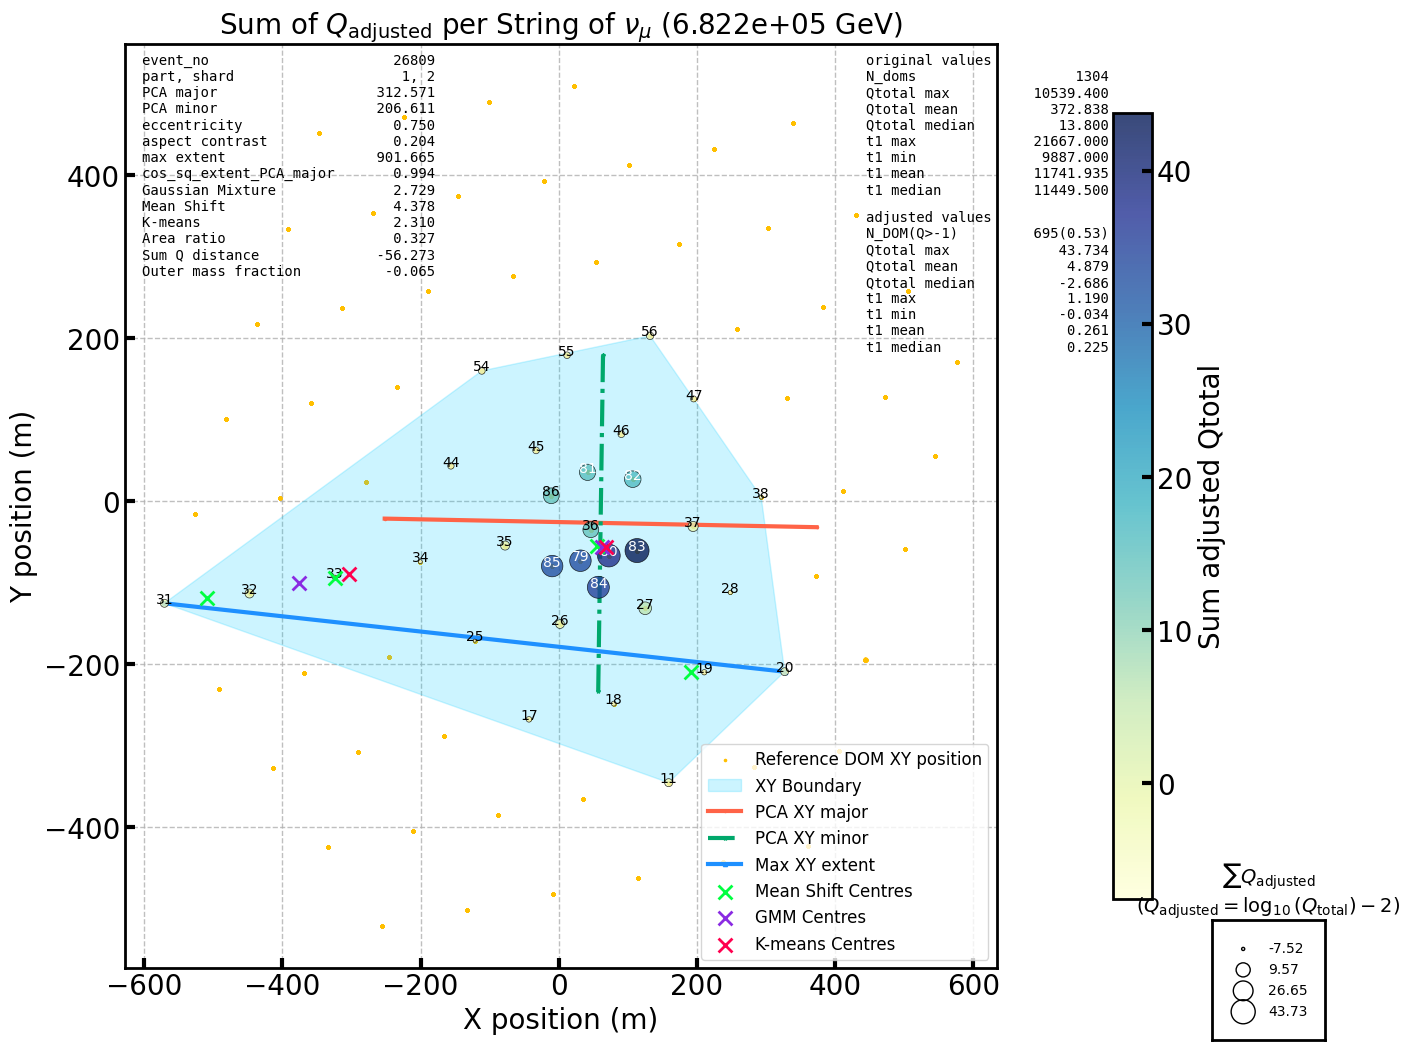

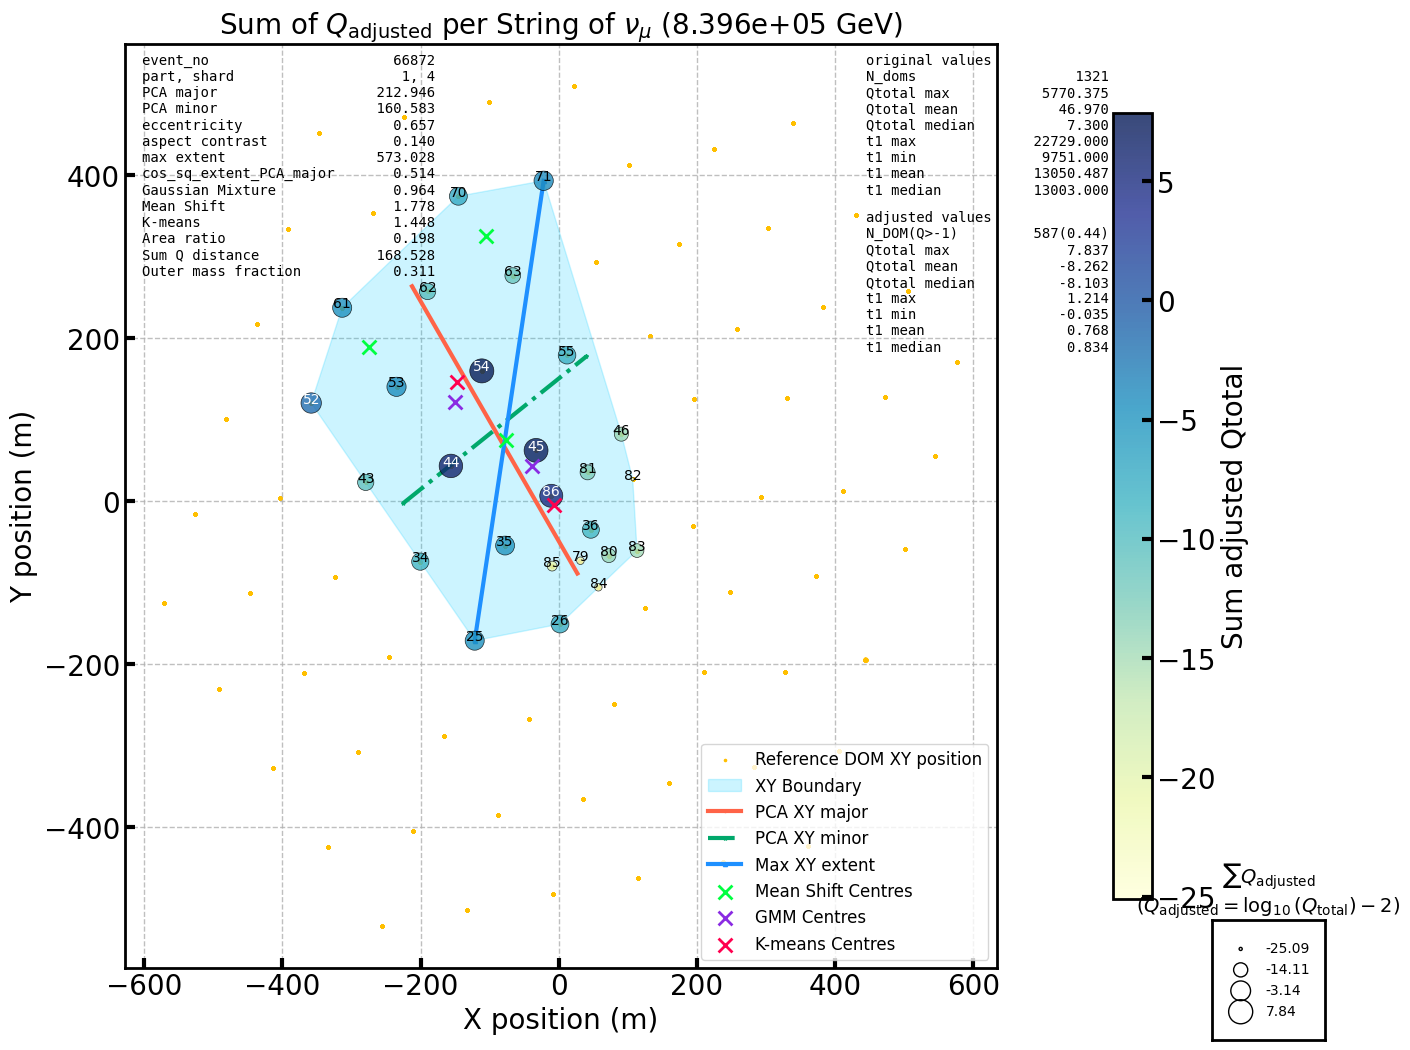

In [601]:
plot_events_from_this_part(root_before_subdir = root_dir_noCR_CC_IN, 
                           subdir = EnergyRange.ER_10_TEV_1_PEV.MU,
                           part = 1, 
                           N_doms_cut = 1300, 
                           Q_cut=-1, elev=50, azim=105)
# 

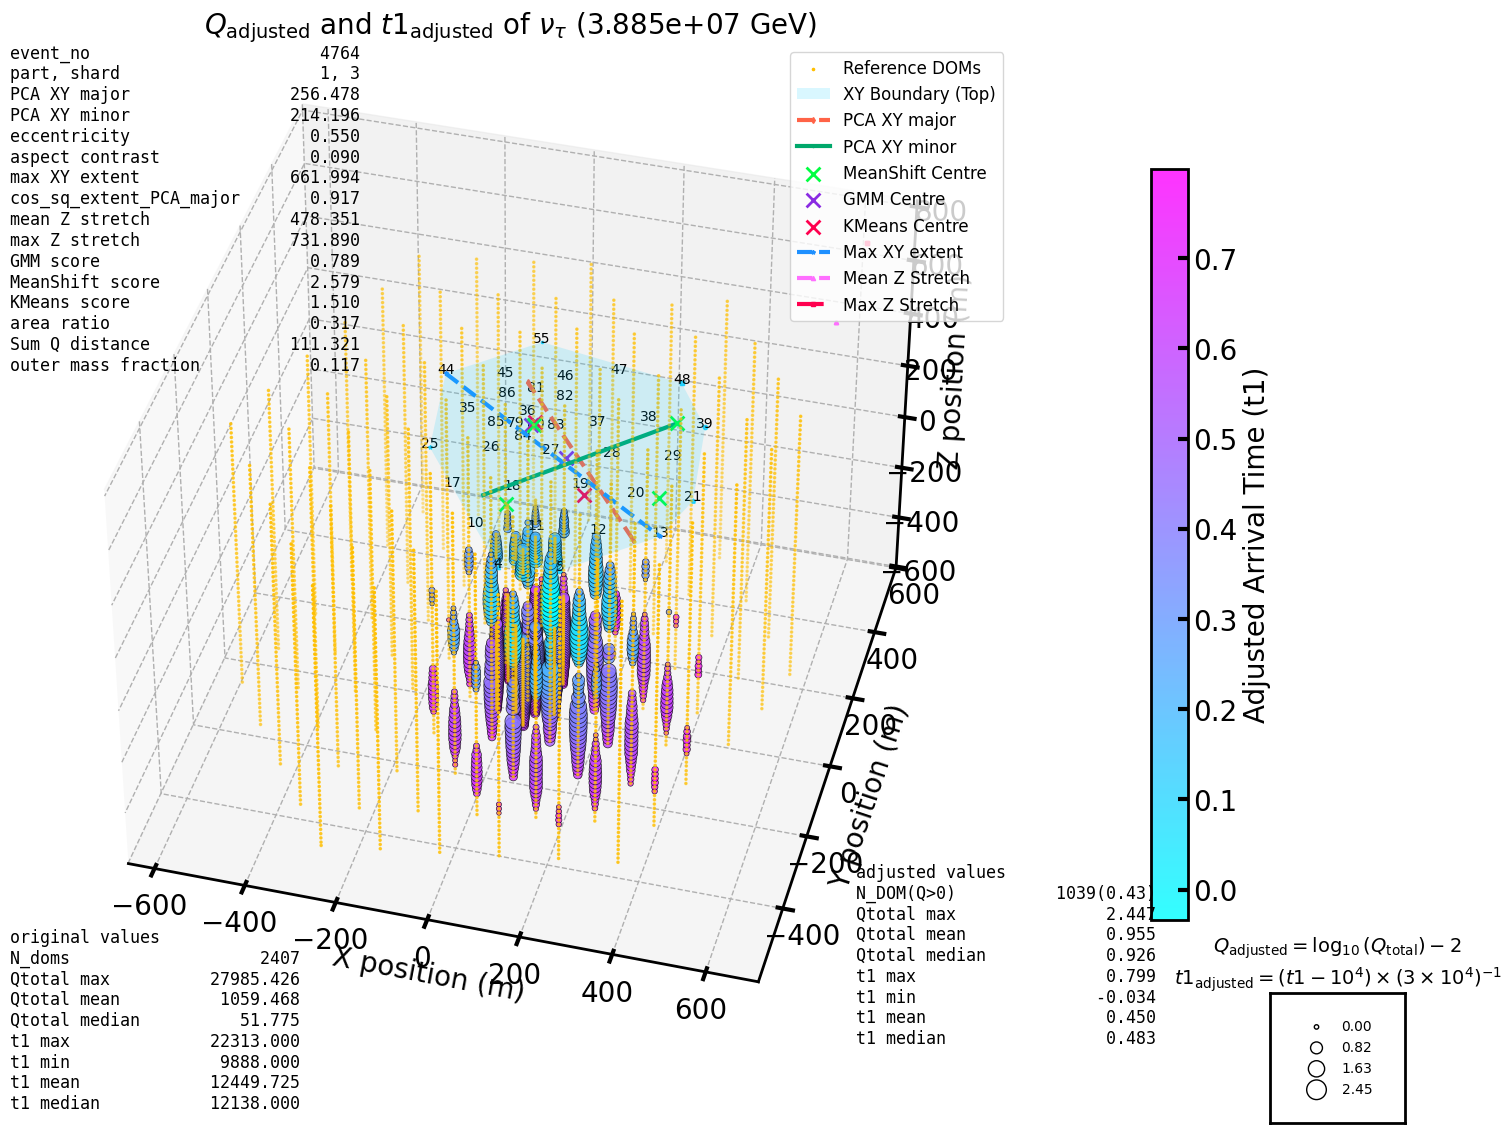

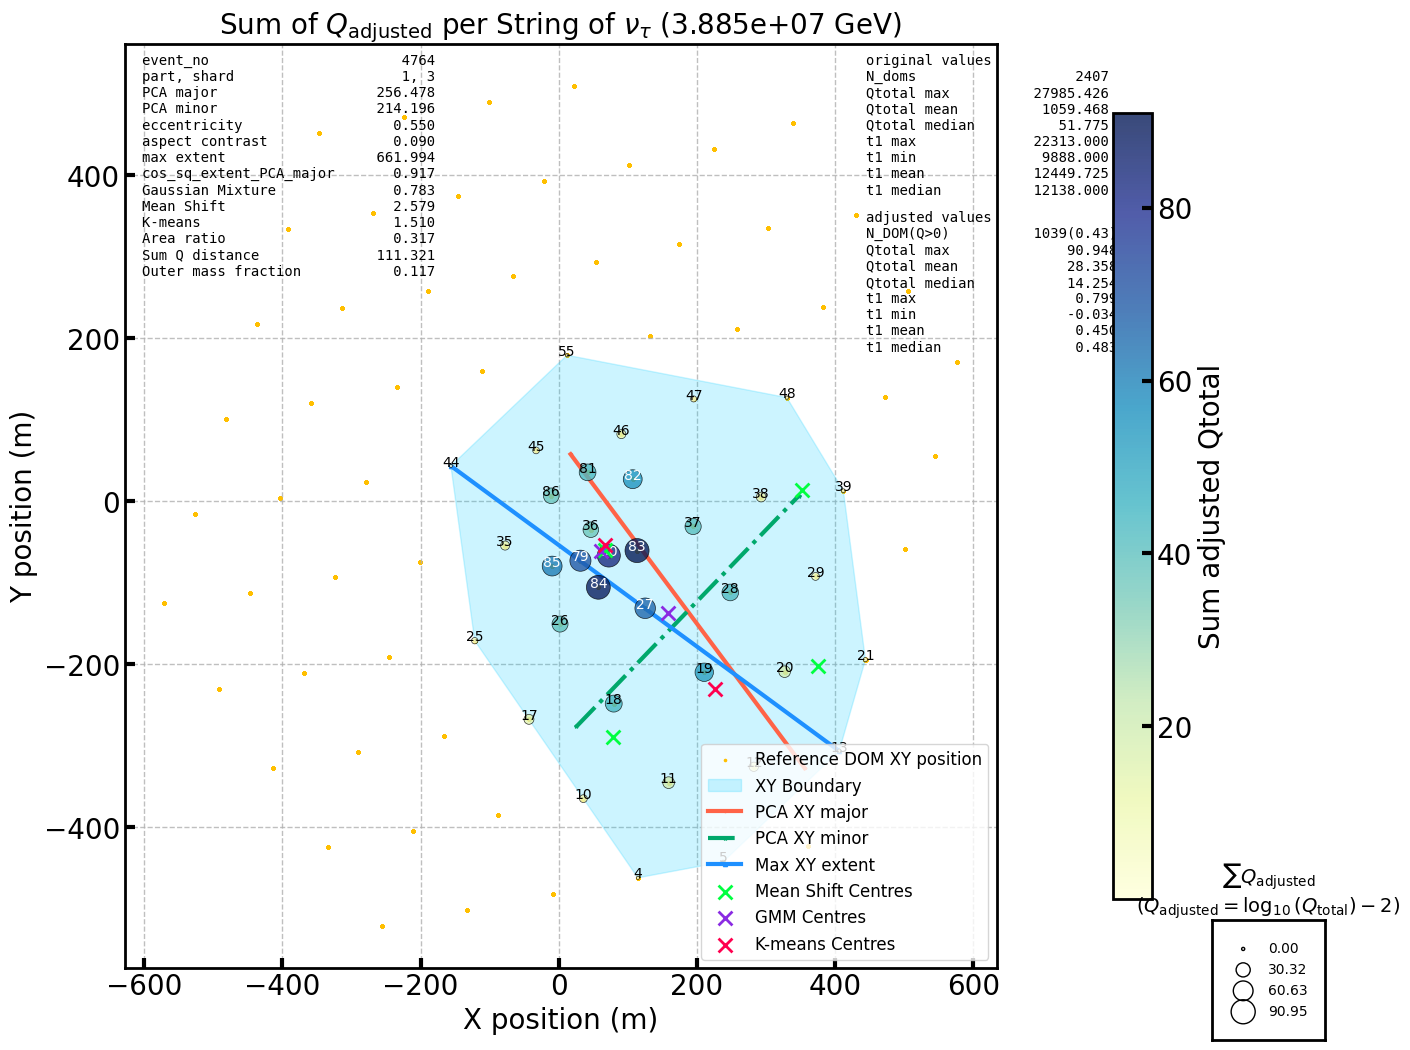

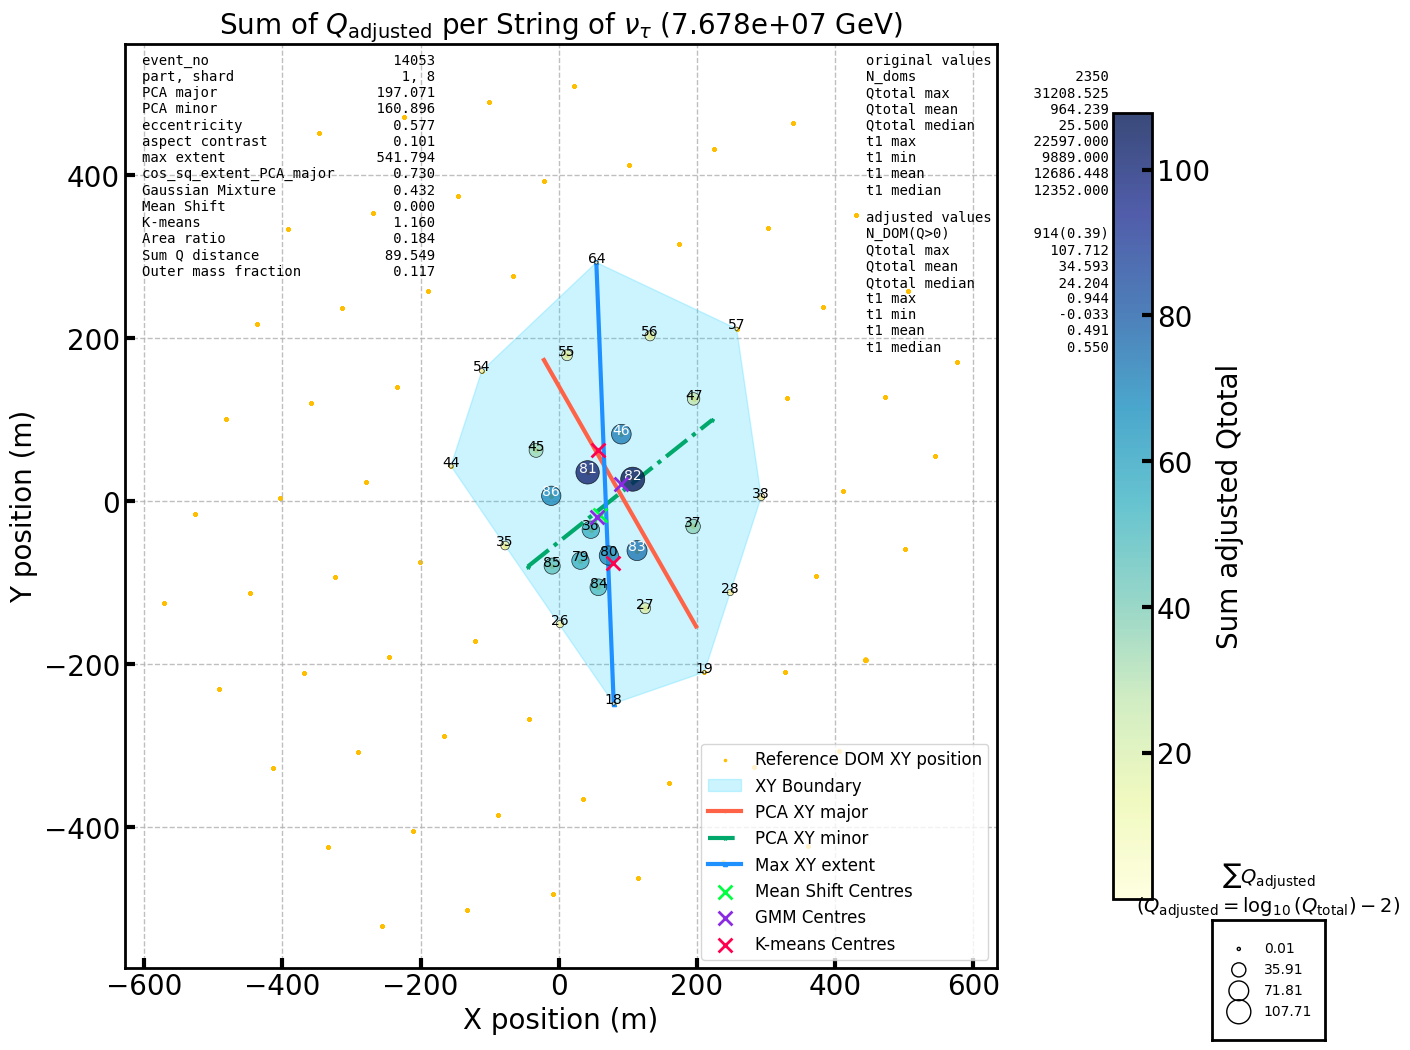

In [596]:
plot_events_from_this_part(root_before_subdir = root_dir_noCR_CC_IN, 
                           subdir = EnergyRange.ER_1_PEV_100_PEV.TAU, 
                           part = 1, 
                           N_doms_cut = 2300, 
                           Q_cut=0, elev=40, azim=105)
# 

$$
Q_{\text{shifted}} = \log_{10}(Q) - 2
$$


In [597]:
# def plot_events_from_this_subdir(root_before_subdir:str, subdir:str):
#     subdir_path = os.path.join(root_before_subdir, subdir)
#     files = [f for f in os.listdir(subdir_path) if f.endswith(".parquet")]
#     for file in files:
#         part = int(file.split("_")[-1].split(".")[0])
#         plot_events_from_this_part(root_before_subdir, subdir, part)

In [560]:
# plot_events_from_this_subdir(root_dir_noCR_CC_IN, EnergyRange.ER_10_TEV_1_PEV.E)

In [561]:
def save_plots_to_pdf(root_dir: str, 
                      er: EnergyRange, 
                      flavour: Flavour, 
                      output_pdf_dir:str, 
                      output_pdf_file:str, 
                      N_doms_cut:int = 1250):
    os.makedirs(output_pdf_dir, exist_ok=True)

    output_pdf_path = os.path.join(output_pdf_dir, output_pdf_file)
    subdir = EnergyRange.get_subdir(er, flavour)
    with PdfPages(output_pdf_path) as pdf:
        # Get all events from this subdir
        subdir_path = os.path.join(root_dir, subdir)
        files = [f for f in os.listdir(subdir_path) if f.endswith(".parquet")]
        
        for file in files:
            part = int(file.split("_")[-1].split(".")[0])
            # Process and generate plots for each part
            interesting_events = get_interesting_events(truth_file = os.path.join(subdir_path, file), N_doms_cut=N_doms_cut)
            energy_range = EnergyRange.get_energy_range(subdir).latex
            title_for_energy_spectrum = f"${flavour.latex}$,  {energy_range}   (part {part})"
            
            # Get energy distribution plot
            fig, ax = get_energy_distribution_from_truth_file(os.path.join(subdir_path, file), title=title_for_energy_spectrum)
            pdf.savefig(fig)  # Save the energy distribution plot
            plt.close(fig)  # Close the figure to free memory
            
            for event_no, shard_no, energy in interesting_events.values:
                pmt_shard_df = pq.read_table(os.path.join(subdir_path, str(part), f"PMTfied_{int(shard_no)}.parquet")).to_pandas()
                pmt_event_df = pmt_shard_df[pmt_shard_df["event_no"] == event_no]
                
                # Get DOM heatmap plot
                fig, ax = plot_DOM_heatmap_for_this_event(pmt_event_df, shard_no, energy)
                pdf.savefig(fig)  # Save the DOM heatmap plot
                plt.close(fig)  # Close the figure to free memory


In [562]:
pdf_dir = "/lustre/hpc/icecube/cyan/factory/DOMification/EventPeek/"

In [563]:
# save_plots_to_pdf(root_dir_noCR_CC_IN, EnergyRange.ER_10_TEV_1_PEV, Flavour.TAU, pdf_dir, "EventPeek_nu_tau_10TeV_1PeV.pdf", N_doms_cut=1200)
# 1250: 12 sec
# 1200: 62 sec

In [564]:
# save_plots_to_pdf(root_dir_noCR_CC_IN, EnergyRange.ER_10_TEV_1_PEV, Flavour.E, pdf_dir, "EventPeek_nu_e_10TeV_1PeV.pdf", N_doms_cut=1250)

In [565]:
# save_plots_to_pdf(root_dir_noCR_CC_IN, EnergyRange.ER_10_TEV_1_PEV, Flavour.MU, pdf_dir, "EventPeek_nu_mu_10TeV_1PeV.pdf", N_doms_cut=1250)

### double bang: 
1. first $\nu_{\tau}$ CC interaction
2. $\tau$ decay
* the distance between the two cascades depends on the tau decay length   
[tau decay length $<L_{\tau}> \approx 50 \cdot E_\tau (m/PeV)$](https://arxiv.org/abs/1908.05506)
  * 1 Pev tau decay length is 50 meters
  * 10 Pev tau decay length is 500 meters
  * 100 Pev tau decay length is 5000 meters